---
Predicting Diabaetes

Jaden Lai

2024-07-21

---


In [2]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)

diabetes <- read.csv("diabetes.csv", header = TRUE, sep = ",")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


A

# **Introduction & Data Description**

Let us start by loading the dataset to be used in this analysis. We will use the dataset `diabetes`, originally from the National Institute of Diabetes and Digestive and Kidney Diseases. This dataset contains information a variety of body measurements of 768 female patients at least 21 years old of Pima Indian heritage and whether they have diabetes or not. We will use the variable `Outcome` as the response variable and a subset of 8 variables to build different models. 

In [3]:
head(diabetes, 3)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35            0       33.6
2 1            85     66            29            0       26.6
3 8           183     64             0            0       23.3
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1

The 9 variables in this dataset are:

- `Pregnancies`: To express the number of pregnancies.
- `Glucose`: To express the glucose level in blood.
- `BloodPressure`: To express the blood pressure measurement.
- `SkinThickness`: To express the thickness of the skin.
- `Insulin`: To express the insulin level in blood.
- `BMI`: To express the body mass index.
- `DiabetesPedigreeFunction`: To express the diabetes percentage.
- `Age`: To express the age.
- `Outcome`: To express the final result where 1 indicates diabetes and 0 indicates no diabetes.

# **Question**

Which variables will create the a logistic regression model with the best *out-of-sample* prediction performance? In other words, which explanatory variables in `diabetes` best predict the value of `Outcome` in *out-of-sample* prediction performance?

- This question uses `Outcome` as our random variable of interest and all of the explanatory variables in our data.
- The data addresses the question of interest by providing us with information and values for each variable that may pose as possible risks for diabetes.
- The question focuses primarily on prediction since we want to find the variables with best *out-of-sample* prediction performance.

# **Exploratory Data Analysis and Visualization**

We have loaded the data set as shown above. Now we can take a look at this data.

In [4]:
head(diabetes, 3)
nrow(diabetes)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35            0       33.6
2 1            85     66            29            0       26.6
3 8           183     64             0            0       23.3
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1

[1] 768

There are 768 patients recorded in this dataset.

`Outcome` is our response variable in our model which is either 1 or 0. Thus, we should convert it from type `integer` to type `factor`.

In [5]:
diabetes$Outcome <- as.factor(diabetes$Outcome)

In [6]:
nrow(diabetes)

[1] 768

Notice that there are 768 observations in this dataset.

We can see that all missing values were filled with 0 instead of NA. We know that this is true for variables `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` for any patient since 0 is not plausible for these measurements. Now we clean `diabetes` to create `diabetes_clean`.

In [7]:
diabetes_clean <- diabetes %>%
  filter(Glucose != 0,
         BloodPressure != 0,
         SkinThickness != 0,
         Insulin != 0,
         BMI != 0)

head(diabetes_clean, 3)
nrow(diabetes_clean)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 1            89     66            23             94     28.1
2 0           137     40            35            168     43.1
3 3            78     50            32             88     31.0
  DiabetesPedigreeFunction Age Outcome
1 0.167                    21  0      
2 2.288                    33  1      
3 0.248                    26  1

[1] 392

There are now 392 observations in this dataset.

Now let's observe pair plots to explore a potential problem of multicollinearity and how each variable might be related to `Outcome`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


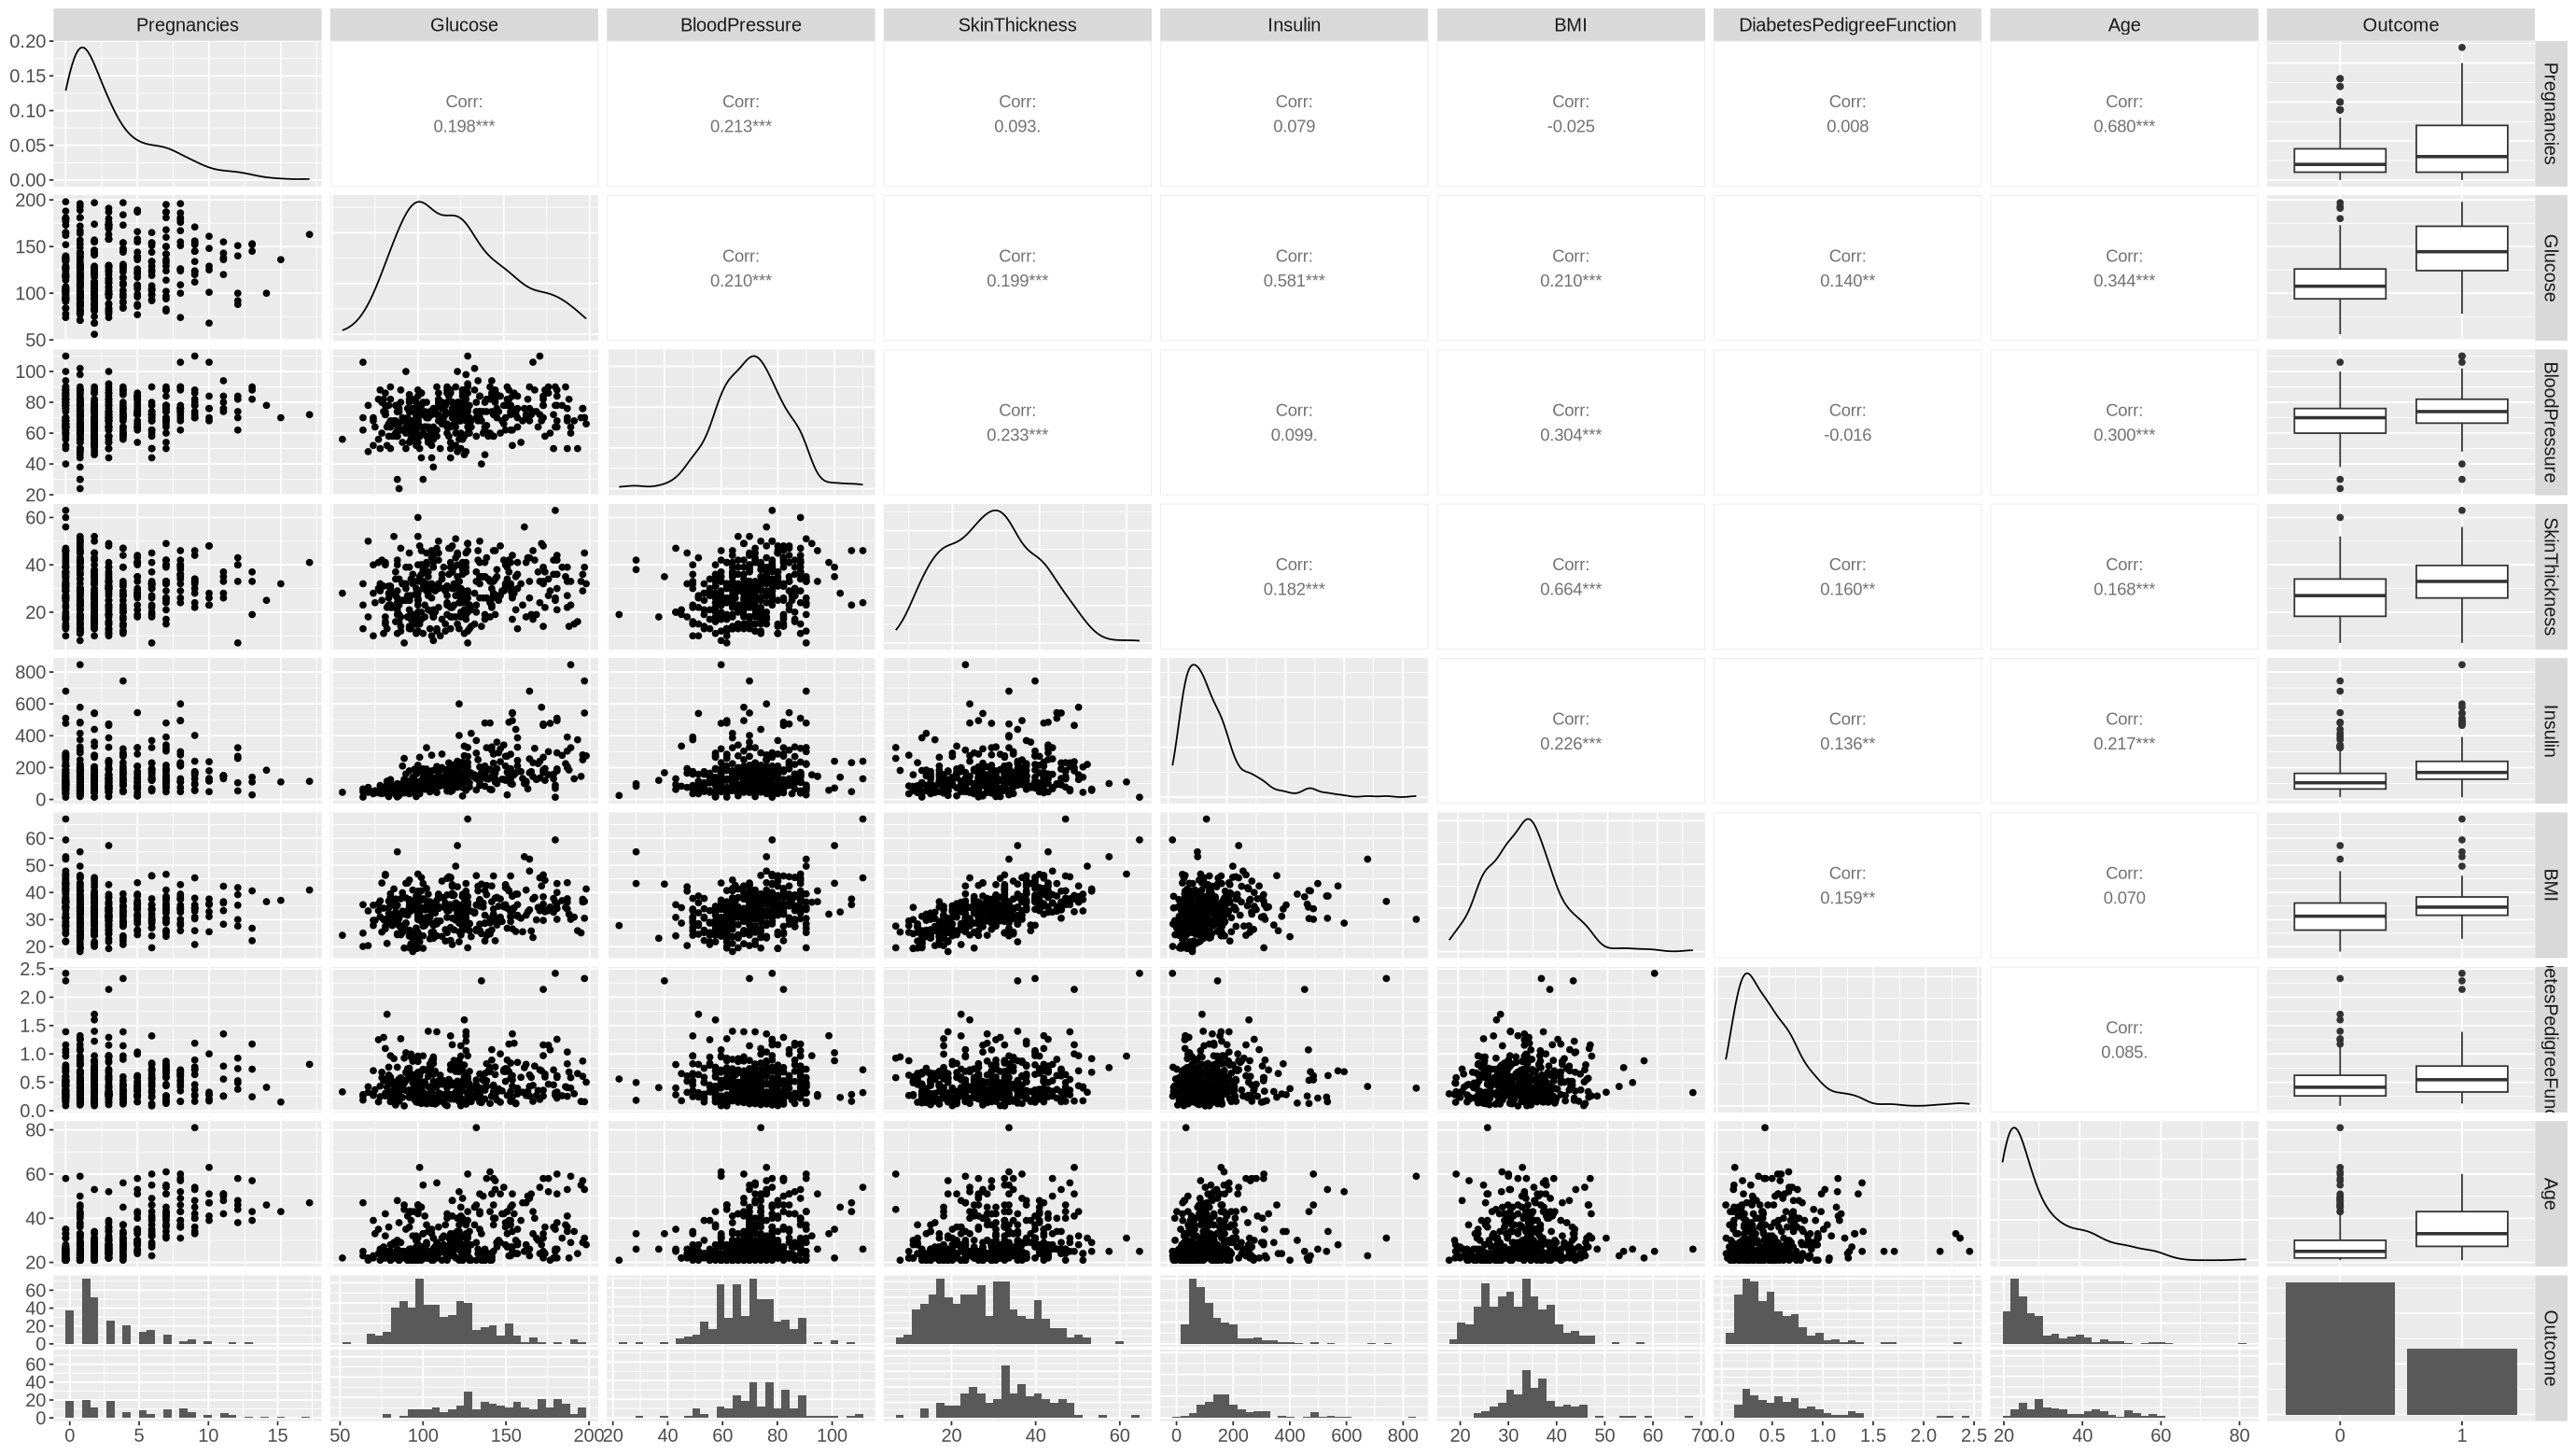

In [8]:
options(repr.plot.width = 23, repr.plot.height = 13) 

diabetes_pair_plots <- 
  diabetes_clean %>%
  ggpairs(progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
diabetes_pair_plots

For any absolute correlation greater than 0.6, we say that it is high. We see that there is a high correlation between `Age` and `Pregnancies`, and `BMI` and `SkinThickness`.

By looking at the `Outcome` column furthest to the right, we see that the median for every explanatory variable in a patient *with* diabetes is higher. For `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, and `Age`, we see a noticable increase in interquartile range for patients *with* diabetes compared to those without diabetes. Specifically, the interquartile range for `Glucose`, `Insulin`, `BMI`, and `Age` of patients with diabetes is higher than their corresponding median value of patients without diabetes. This plot suggests that `Glocuse`, `Insulin`,`BMI`, and `Age` in our most accurate models could be more plausible, whereas variables iwth higher correlation may not.

# **Methods and Plan**

The method I plan to use to address the question of interest is forward selection. Initially, I will split `diabetes_clean` into training and testing sets so we can evaluate out-of-sample prediction performance. The forward selection process will be employed by `stepwise()` from the StepReg package to access the most accurate model. This method is appropiate since it finds the most accurate models across sizes 1 to 8 predictors variables and allows us to compare out-of-sample between these models.

An assumption of forward selection is that no variables should be perfectly collinear. Some underlying assumptions for our logistic regression model include a binary response variable, independence of observations, and no perfect multicollinearity.

Forward selection may struggle with mnulticollinear variables and may be biased towars variables that appaer significant by chance. Another weakness for logistic regression includes our assumption that there is a linear relationship between the independent explanatory variables and our response. It may not capture non-linear patterns within our levels of `Outcome`.